## 1. Modelos Generativos

### 1.1 *Variational Autoencoder* (VAE)

In [129]:
import matplotlib.pyplot as plt

In [130]:
from keras.datasets import mnist
from keras.layers import Lambda
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
from scipy.stats import norm
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [131]:
#Falta una dimension correspondiente a los canales, por lo que se agrega
X_train=np.reshape(X_train,(-1,28,28,1))
X_test=np.reshape(X_test,(-1,28,28,1))
###
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
img_rows, img_cols = X_train.shape[1:3]
channel=1

Primero se cargan las imágenes utilizadas en las tareas anteriores. Son imágenes de $28\times28$ en escala de grises con valores en $[0,255]$, escalados para estar entre $[0,1]$.

Parte a)

In [132]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [133]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 258       
Total para

El modelo mostrado corresponde a la sección codificadora del autoencoder. En primer lugar se tienen tres capas convolucionales y luego unas densas para la reducción de dimensionalidad. La capa densa más pequeña está a conectada con dos capas, *z_mean* y *z_log_var*.

Las capas convolucionales tienen la labor de identificar features de las imágenes, generando feature maps para este motivo. Por otro lado, las capas densas con prefijo "z" tienen la labor de aprender sobre las variables latentes de los datos. Notar que estas últimas tienen de manera predeterminada 2 dimensiones, que indican la evaluación de 2 variables latentes.

Parte b)

**Convolución transpuesta** es el proceso de generar una convolución de datos de menor dimensión a uno de igual o mayor. El proceso no es equivalente a revertir la convolución original (si es que hubo una previamente) pero sí es posible restaurar dimensiones de esta manera.

Los strides indican la distancia con la que se encuentran los datos originales, por ejemplo en el caso de las imágenes, con stride 1 la convolución será hecha sobre la imagen original, mientras que con stride 2 cada dato tendrá un pixel de distancia.

In [137]:
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

En este caso, como se utiliza padding *same*, la imagen resultante tendrá las mismas dimensiones que la original.

Parte c)

In [138]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_6 

El modelo completo es el *Variational Autoencoder*. Este primero recibe una imagen de $28\times28$ y a través de convoluciones disminuye sus dimensiones a $14\times14$ con 64 canales. Luego se llevan a capas densas con 1 dimensión de 12,544 elementos y posteriormente se disminuye a 128 elementos. Toda esta sección corresponde al encoder del modelo.

Las capas *dense_20* y *dense_21* ambas están conectadas a la salida de 128 elementos y tienen la labor de aprender sobre las variables latentes de los datos originales.

En la entrada de la sección de decoding, el modelo posee una capa *lambda_4* que toma como argumentos las variables latentes y las utiliza para otorgar variaciones a las imágenes producidas. Finalmente esta imagen modificada, con baja dimensionalidad luego es aumentada con capas densas y convoluciones transpuestas, utilizando las mismas dimensiones que en la sección de enconding.

Parte d)

La función de pérdida elegida fue MSE ya que esta es útil para problemas de regresión, en contraste con binary-crossentropy que es utilizado para problemas de clasificación. **EXTENDERRRRRRRR**

In [139]:
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_6 

KL-divergencia indica la diferencia entre dos tipos de distribuciones, con valor máximo $1$ cuando el comportamiento de las distribuciones son muy distintas. Por otro lado, con valor $0$ estas se comportan de manera parecida, si no idénticamente.

Por lo anterior, utilizar KL-divergencia ofrece una forma fácil para identificar las variables latentes de los datos originales y por extensión reconocer su distribución.

Parte e)

In [140]:
batch_size = 128
epochs =15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_12" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 21s 351us/step - loss: 186.0714 - val_loss: 163.4744
Epoch 2/15
60000/60000 [==============================] - 20s 330us/step - loss: 158.3536 - val_loss: 154.8950
Epoch 3/15
60000/60000 [==============================] - 20s 336us/step - loss: 153.1813 - val_loss: 151.6662
Epoch 4/15
60000/60000 [==============================] - 20s 327us/step - loss: 150.2859 - val_loss: 150.9138
Epoch 5/15
60000/60000 [==============================] - 20s 332us/step - loss: 148.3829 - val_loss: 148.8097
Epoch 6/15
60000/60000 [==============================] - 20s 329us/step - loss: 146.9459 - val_loss: 146.5699
Epoch 7/15
60000/60000 [==============================] - 20s 338us/step - loss: 145.8238 - val_loss: 145.8345
Epoch 8/15
60000/60000 [==============================] - 20s 331us/step - loss: 144.7698 - val_loss: 144.3421
Epoch 9/15
60000/60000 [==============================] - 20s 

Parte f)

Se genera el gráfico de la representación en el espacio latente de cada número.

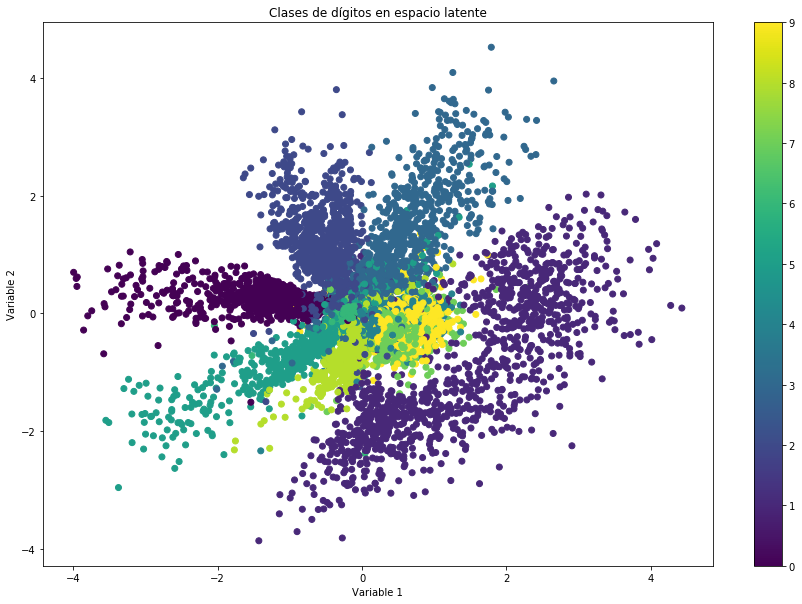

In [141]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

En la figura se puede observar como números de distintas categorías tienden a agruparse en el espacio latente, siendo más evidente en números como el 0 y el 1. Algunas clases se mezclan, como es el caso del 9, que comparte espacio con clases como el 4 y el 7.

Más importante, notar que en general todas las clases están cercanas unas a otras, lo cuál indica que el modelo es capaz de producir imágenes intermedias (que se mueven dentro del espacio ilustrado) y que además este mismo pueda interpretar como una clase (o número, en este caso). Variaciones que disten mucho del centro corresponderían a imágenes inentendibles por el modelo.

Luego se generan los histogramas de las medias y las varianzas de las variables latentes.

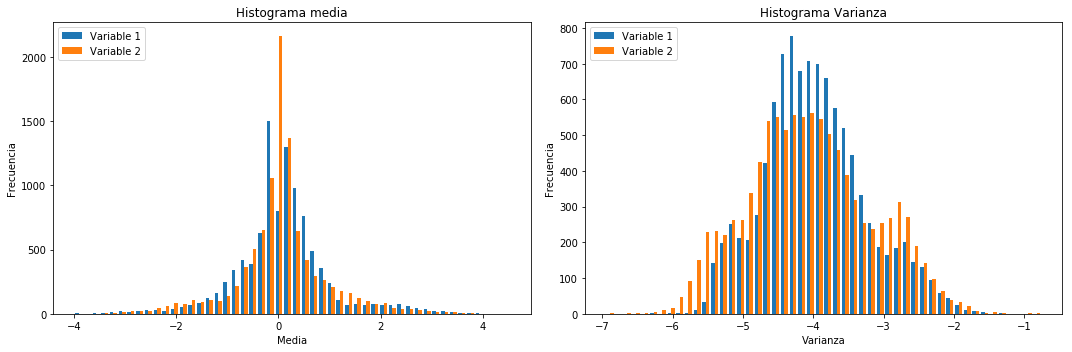

In [142]:
encoder_log_var = Model(x,z_log_var)
#histogram
x_test_log_var=encoder_log_var.predict(X_test,batch_size=batch_size)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
leg=["Variable 1","Variable 2"]
ax[0].hist(x_test_encoded, 50)
ax[1].hist(x_test_log_var, 50)
ax[0].set_title('Histograma media')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Media')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Histograma Varianza')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Varianza')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

En el histograma de medias se puede apreciar que ambas variables están cercanas al cero, con la variable 2 un poco más desplazada hacia los negativos. Esta evaluación coincide con el sampleo utilizado en la función lambda del modelo, cuya media también es 0.

El histograma indica la distribución de los números respecto al espacio latente, lo cuál es equivalente a considerar solamente un eje en términos posicionales y presentarlos en función a su frecuencia.

Parte g)

La siguiente figura es equivalente a la figura de puntos en el ítem anterior, sin embargo en lugar de ilustrar puntos, se presentan los símbolos de salida que produce el modelo. Para comparar se presentan los gráficos uno tras otro. 

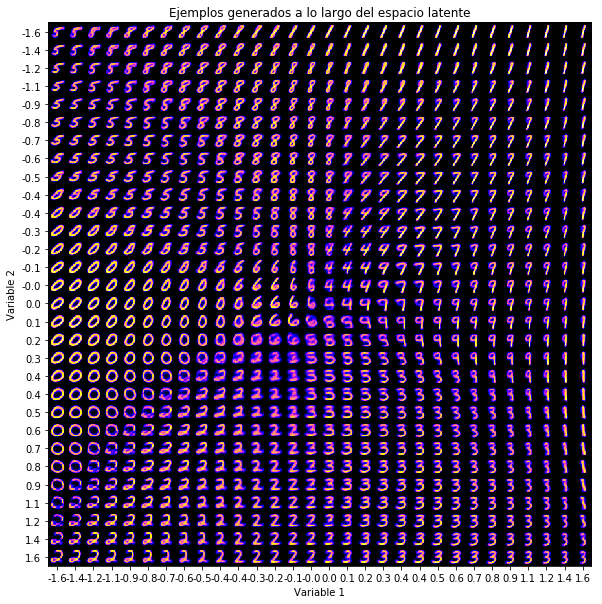

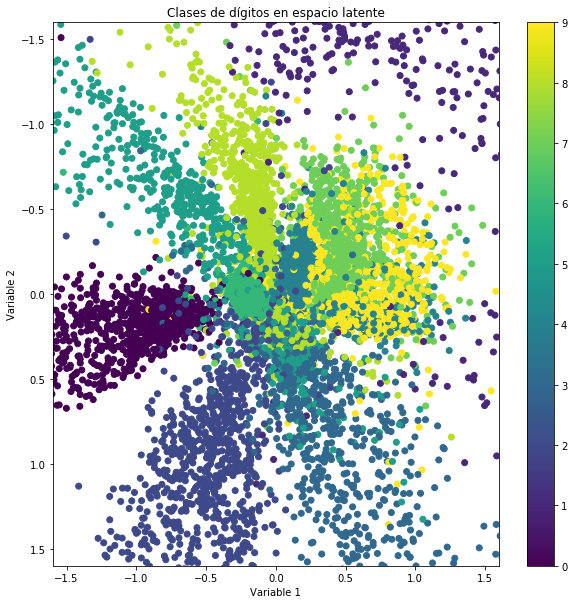

In [143]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.title("Ejemplos generados a lo largo del espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.show()

x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.xlim(-1.6,1.6)
plt.ylim(1.6,-1.6)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

Ambos gráficos representan el espacio latente, y se puede observar una correspondencia entre la ubicación del área clasificada como *uno* en el gráfico de dispersión y símbolos parecidos a unos en el de ejemplos.

Además, áreas que están altamente pobladas por puntos mezclados presentan combinaciones de símbolos en el primer gráfico, particularmente con los *nueves*. Esto denota la dificultad de identificación que tiene el modelo frente a estos números.

Luego, se produce el mismo gráfico aumentando el intervalo de confianza.

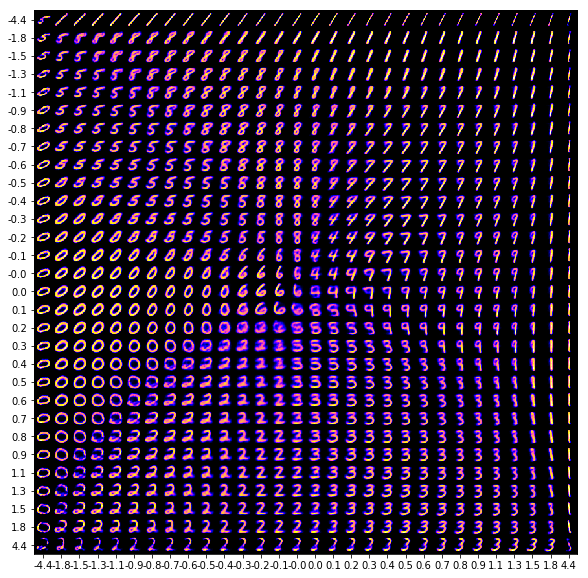

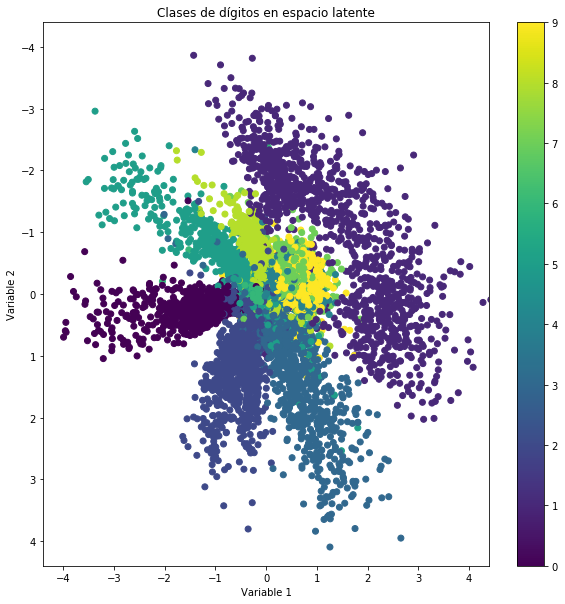

In [144]:
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))
grid_x = grid
grid_y = grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(10,10))
plt.xlim(-4.4,4.4)
plt.ylim(4.4,-4.4)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title("Clases de dígitos en espacio latente")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.colorbar()
plt.show()

En los extremos se ilustran símbolos no encontrados en el conjunto de datos, como bien indica el gráfico de dispersión. Estos símbolos, sobretodo en las esquinas de la figura, son distorsiones de los símbolos originales y resultan de una "saturación" en las variables latentes, resultando en variaciones extremas y distantes del set de datos original.

Parte h)

In [146]:
K.eval(K.random_uniform((1,),0,1))

array([0.64484036], dtype=float32)

In [98]:
def samplingUniform(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_uniform(shape=(K.shape(z_mean)[0], latent_dim),minval=0., maxval=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

In [97]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_lambda = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)


shape_before_flattening = K.int_shape(conv_3)[1:]
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')



z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)


#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

AttributeError: module 'keras.backend' has no attribute 'random_poisson'

In [58]:
batch_size = 128
epochs =15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_15" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 21s 343us/step - loss: 1468.6865 - val_loss: 39.1283
Epoch 2/15
57472/60000 [===========================>..] - ETA: 0s - loss: 37.4614

KeyboardInterrupt: 

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure((15,10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
#histogram

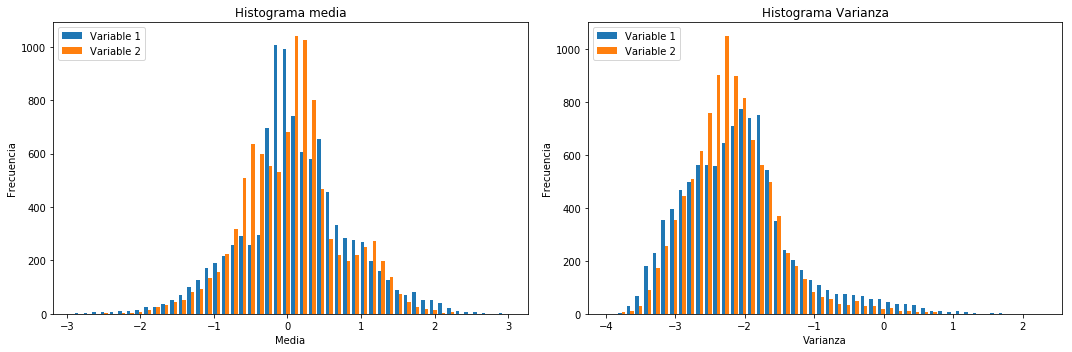

In [17]:
encoder_log_var = Model(x,z_log_var)
#histogram
x_test_log_var=encoder_log_var.predict(X_test,batch_size=batch_size)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
leg=["Variable 1","Variable 2"]
ax[0].hist(x_test_encoded, 50)
ax[1].hist(x_test_log_var, 50)
ax[0].set_title('Histograma media')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Media')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Histograma Varianza')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Varianza')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

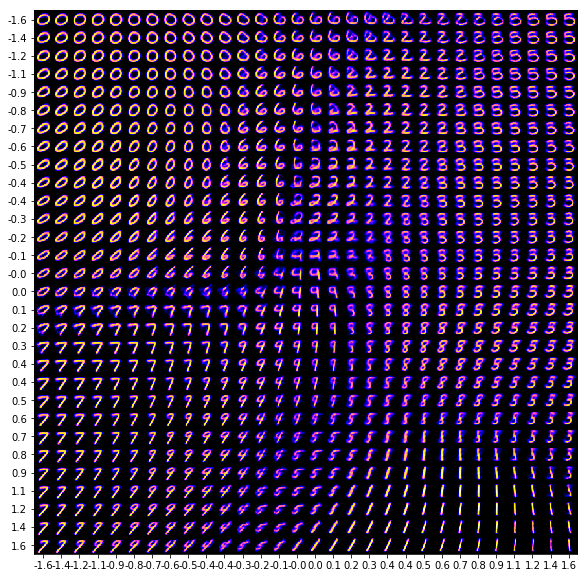

In [18]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm,gamma
#metodo de la transformada inversa
grid_x = uniform.ppf(np.linspace(0.05, 0.95, n))
grid_y = uniform.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

Parte i)

Para comprobar el impacto de la dimensionalidad en el desempeño del modelo, sencillamente se compararán las pérdidas de cada modelo durante entrenamiento.

In [173]:
historias=[]
dimensiones=[2,3,4,5,8,10,20]
for latent_dim in dimensiones:
    x = Input(shape=original_img_size)
    conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
    conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
    conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
    flat = Flatten()(conv_3)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    z_mean = Dense(latent_dim,activation='linear')(hidden)
    z_log_var = Dense(latent_dim,activation='linear')(hidden)
    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)


    decoder_hid = Dense(intermediate_dim, activation='relu')
    decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
    decoder_reshape = Reshape(shape_before_flattening)
    decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
    decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
    decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')



    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    hid_decoded = decoder_hid(z)
    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded =  decoder_reshape(up_decoded)
    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    # instantiate VAE model
    vae = Model(x, x_decoded_mean_squash)


    #choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
    choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
    reconstruction_loss = img_rows * img_cols * channel* choised_loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    batch_size = 128
    epochs =10
    vae.compile(optimizer='rmsprop',metrics=['accuracy'])
    hist=vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))
    historias.append(hist)

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_30" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 347us/step - loss: 46.0648 - val_loss: 39.3847
Epoch 2/10
60000/60000 [==============================] - 20s 327us/step - loss: 38.3988 - val_loss: 37.3249
Epoch 3/10
60000/60000 [==============================] - 20s 327us/step - loss: 36.8143 - val_loss: 36.6007
Epoch 4/10
60000/60000 [==============================] - 20s 328us/step - loss: 35.8392 - val_loss: 35.5703
Epoch 5/10
60000/60000 [==============================] - 20s 328us/step - loss: 35.2218 - val_loss: 35.5439
Epoch 6/10
60000/60000 [==============================] - 20s 328us/step - loss: 34.7011 - val_loss: 35.1086
Epoch 7/10
60000/60000 [==============================] - 20s 329us/step - loss: 34.3249 - val_loss: 34.4360
Epoch 8/10
60000/60000 [==============================] - 20s 330us/step - loss: 34.0075 - val_loss: 34.2352
Epoch 9/10
60000/60000 [==============================] - 20s 329us/step - los

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_33" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_33" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 352us/step - loss: 44.2640 - val_loss: 36.0594
Epoch 2/10
60000/60000 [==============================] - 20s 329us/step - loss: 34.6733 - val_loss: 33.3470
Epoch 3/10
60000/60000 [==============================] - 20s 329us/step - loss: 32.7175 - val_loss: 31.9583
Epoch 4/10
60000/60000 [==============================] - 20s 328us/step - loss: 31.6505 - val_loss: 31.9815
Epoch 5/10
60000/60000 [==============================] - 20s 329us/step - loss: 30.9491 - val_loss: 30.2751
Epoch 6/10
60000/60000 [==============================] - 20s 329us/step - loss: 30.3990 - val_loss: 31.1998
Epoch 7/10
60000/60000 [==============================] - 20s 327us/step - loss: 29.9977 - val_loss: 30.8892
Epoch 8/10
60000/60000 [==============================] - 20s 329us/step - loss: 29.6516 - val_loss: 29.6001
Epoch 9/10
60000/60000 [==============================] - 20s 328us/step - los

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_36" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_36" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 354us/step - loss: 127.9420 - val_loss: 35.9783
Epoch 2/10
60000/60000 [==============================] - 20s 325us/step - loss: 33.4528 - val_loss: 32.0538
Epoch 3/10
60000/60000 [==============================] - 20s 325us/step - loss: 30.8368 - val_loss: 29.8697
Epoch 4/10
60000/60000 [==============================] - 19s 324us/step - loss: 29.5875 - val_loss: 28.9769
Epoch 5/10
60000/60000 [==============================] - 20s 327us/step - loss: 28.7714 - val_loss: 28.4277
Epoch 6/10
60000/60000 [==============================] - 20s 326us/step - loss: 28.1721 - val_loss: 27.9296
Epoch 7/10
60000/60000 [==============================] - 19s 324us/step - loss: 27.6910 - val_loss: 27.3935
Epoch 8/10
60000/60000 [==============================] - 20s 336us/step - loss: 27.2728 - val_loss: 27.4793
Epoch 9/10
60000/60000 [==============================] - 20s 327us/step - lo

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_39" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_39" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 353us/step - loss: 40.6704 - val_loss: 32.2224
Epoch 2/10
60000/60000 [==============================] - 20s 327us/step - loss: 29.8355 - val_loss: 28.7873
Epoch 3/10
60000/60000 [==============================] - 20s 327us/step - loss: 27.8925 - val_loss: 27.4160
Epoch 4/10
60000/60000 [==============================] - 20s 330us/step - loss: 26.7737 - val_loss: 26.1261
Epoch 5/10
60000/60000 [==============================] - 20s 329us/step - loss: 26.0271 - val_loss: 25.5384
Epoch 6/10
60000/60000 [==============================] - 20s 328us/step - loss: 25.4520 - val_loss: 25.1818
Epoch 7/10
60000/60000 [==============================] - 20s 330us/step - loss: 25.0387 - val_loss: 24.8137
Epoch 8/10
60000/60000 [==============================] - 20s 329us/step - loss: 24.6936 - val_loss: 25.1566
Epoch 9/10
60000/60000 [==============================] - 20s 331us/step - los

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_42" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_42" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 353us/step - loss: 35.9791 - val_loss: 27.7086
Epoch 2/10
60000/60000 [==============================] - 20s 327us/step - loss: 26.4510 - val_loss: 25.9674
Epoch 3/10
60000/60000 [==============================] - 20s 327us/step - loss: 24.6786 - val_loss: 23.9211
Epoch 4/10
60000/60000 [==============================] - 20s 330us/step - loss: 23.7707 - val_loss: 23.0667
Epoch 5/10
60000/60000 [==============================] - 20s 328us/step - loss: 23.1317 - val_loss: 23.1679
Epoch 6/10
60000/60000 [==============================] - 20s 326us/step - loss: 22.6913 - val_loss: 22.3980
Epoch 7/10
60000/60000 [==============================] - 19s 325us/step - loss: 22.3378 - val_loss: 22.4871
Epoch 8/10
60000/60000 [==============================] - 20s 328us/step - loss: 22.0365 - val_loss: 21.8904
Epoch 9/10
60000/60000 [==============================] - 20s 325us/step - los

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_45" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_45" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 357us/step - loss: 39.0842 - val_loss: 29.2833
Epoch 2/10
60000/60000 [==============================] - 20s 327us/step - loss: 27.2577 - val_loss: 25.5334
Epoch 3/10
60000/60000 [==============================] - 20s 326us/step - loss: 24.7423 - val_loss: 25.3179
Epoch 4/10
60000/60000 [==============================] - 20s 325us/step - loss: 23.5548 - val_loss: 22.6034
Epoch 5/10
60000/60000 [==============================] - 19s 325us/step - loss: 22.8292 - val_loss: 22.2683
Epoch 6/10
60000/60000 [==============================] - 20s 326us/step - loss: 22.2789 - val_loss: 21.8847
Epoch 7/10
60000/60000 [==============================] - 20s 327us/step - loss: 21.9007 - val_loss: 21.5126
Epoch 8/10
60000/60000 [==============================] - 21s 342us/step - loss: 21.5835 - val_loss: 21.6364
Epoch 9/10
60000/60000 [==============================] - 20s 333us/step - los

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "conv2d_transpose_48" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_48" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 355us/step - loss: 39.3627 - val_loss: 30.5091
Epoch 2/10
60000/60000 [==============================] - 20s 328us/step - loss: 27.5332 - val_loss: 27.2073
Epoch 3/10
60000/60000 [==============================] - 20s 327us/step - loss: 24.6671 - val_loss: 23.0461
Epoch 4/10
60000/60000 [==============================] - 20s 327us/step - loss: 23.3323 - val_loss: 23.7499
Epoch 5/10
60000/60000 [==============================] - 20s 329us/step - loss: 22.5670 - val_loss: 22.5134
Epoch 6/10
60000/60000 [==============================] - 20s 329us/step - loss: 22.0092 - val_loss: 21.7003
Epoch 7/10
60000/60000 [==============================] - 20s 327us/step - loss: 21.5945 - val_loss: 21.8882
Epoch 8/10
60000/60000 [==============================] - 19s 325us/step - loss: 21.2800 - val_loss: 21.0333
Epoch 9/10
60000/60000 [==============================] - 20s 327us/step - los

Como la función de pérdida está asociada a la divergencia de las funciones, una menor pérdida implicará un mejor acercamiento a la distribución de datos.

Se procede a graficar las pérdidas de entrenamiento y de validación.

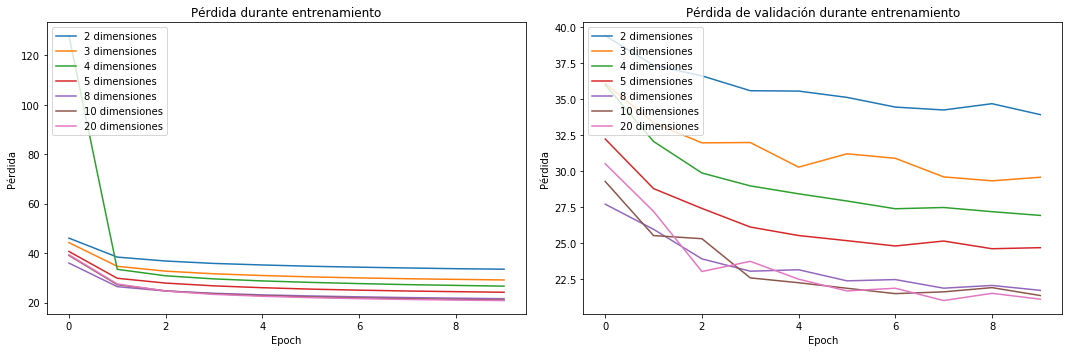

In [190]:
leg=[]
for i in range(len(dimensiones)):
    leg.append(str(dimensiones[i])+" dimensiones")
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
for i in range(len(historias)):
    ax[0].plot(historias[i].history["loss"])
    ax[1].plot(historias[i].history["val_loss"])
ax[0].set_title('Pérdida durante entrenamiento')
ax[0].set_ylabel('Pérdida')
ax[0].set_xlabel('Epoch')
ax[0].legend(leg, loc='upper left')
ax[1].set_title('Pérdida de validación durante entrenamiento')
ax[1].set_ylabel('Pérdida')
ax[1].set_xlabel('Epoch')
ax[1].legend(leg, loc='upper left')
plt.tight_layout()
plt.show()

En los gráficos se puede apreciar que se disminuye le pérdida de las funciones conforme más variables latentes se consideren en el modelo. Esto se puede atribuir a que al considerar más variables, más información latente puede aprender el modelo.

Notar que existe una cota para la cantidad de variables necesarias, notando que con 8, 10 y 20 variables latentes no existe mayor mejora tras los 2 epochs, por lo que se infiere que dependiendo de la naturaleza de los datos, existe una cantidad de variables latentes adecuadas que pueden contener gran parte de la información latente.

Parte j)

In [196]:
original_img_size

(28, 28, 1)

In [215]:
intermediate_dim

128

In [219]:
x = Input(shape=original_img_size)
flat=Flatten()(x)
Dense_1=Dense(784,activation='relu')(flat)
Dense_2=Dense(196,activation='relu')(Dense_1)
Drop1=Dropout(0.25)(Dense_2)
Dense_3=Dense(49,activation='relu')(Drop1)
hidden = Dense(intermediate_dim, activation='relu')(Dense_3)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_hid = Dense(intermediate_dim, activation='relu')
Dense_4=Dense(49,activation='relu')
Dense_5=Dense(196,activation='relu')
Drop2=Dropout(0.25)
Dense_6=Dense(784,activation='sigmoid')

dec_int=decoder_hid(z)
Layer_d4=Dense_4(dec_int)
Layer_d5=Dense_5(Layer_d4)
Layer_drop2=Drop2(Layer_d5)
Layer_d6=Dense_6(Layer_drop2)
Reshap=Reshape(original_img_size)(Layer_d6)

vae2 = Model(x, Reshap)

#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(Reshap))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae2_loss = K.mean(reconstruction_loss + kl_loss)
vae2.add_loss(vae_loss)
vae2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 784)          0           input_32[0][0]                   
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 784)          615440      flatten_23[0][0]                 
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 196)          153860      dense_124[0][0]                  
__________________________________________________________________________________________________
dropout_15

In [220]:
batch_size = 128
epochs =10
vae.compile(optimizer='adam',metrics=['accuracy'])
hist=vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "conv2d_transpose_48" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_48" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
32128/60000 [===============>..............] - ETA: 10s - loss: 18.4448

KeyboardInterrupt: 

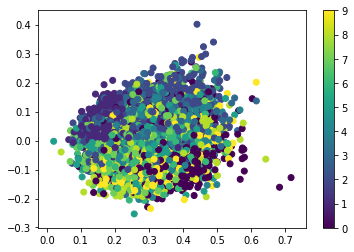

In [208]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
#histogram

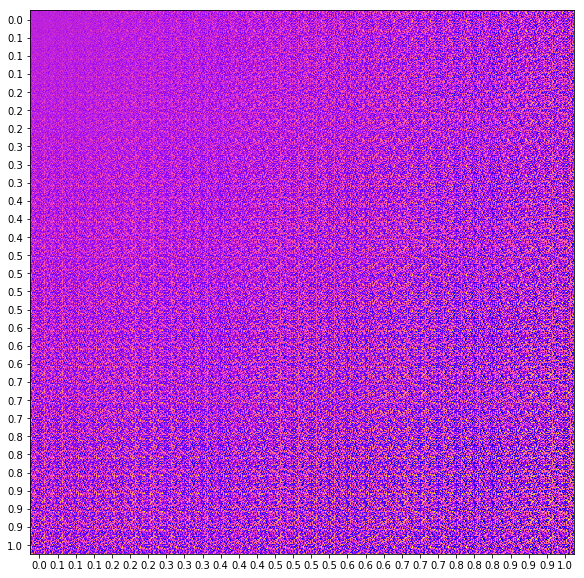

In [218]:
latent_dim=2
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_dec_int=decoder_hid(decoder_input)
_Layer_d4=Dense_4(_dec_int)
_Layer_d5=Dense_5(_Layer_d4)
_Layer_drop2=Drop2(_Layer_d5)
_Layer_d6=Dense_6(_Layer_drop2)
_Reshap=Reshape(original_img_size)(_Layer_d6)

generator = Model(decoder_input, _Reshap)

##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = uniform.ppf(np.linspace(0.05, 0.95, n))
grid_y = uniform.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()

### 1.2 *Generative Adversarial Networks* (GAN)

Parte a)

El discriminador es la sección que se encarga de decidir si la imagen recibidad corresponde o no a una imagen generada por el generador.

In [15]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


La estructura del discriminador consiste en una serie de capas convolucionales con dropout, seguidas por capas densas. Las capas convolucionales son ocupadas para reconocer los patrones de los datos de entrada, mientras que las capas densas tienen la labor de discriminar las imágenes.

Tanto las capas convolucionales como la capa densa con múltiples unidades poseen unidades *LeakyReLU*, las cuales son utilizadas como alternativa a las ReLU tradicionales por evitar el estancamiento de la propagación de la gradiente al permitir el paso de pequeños valores negativos.

La salida del modelo utiliza función sigmoidal **EXTENDERRRR**

Parte b)

El generador se encarga producir imágenes falsas, con la esperanza de que eventualmente logre engañar al discriminador y por extensión aprender la distribución de los datos.

In [16]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_7 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 64)        0         
__________

El generador toma como entrada ruido aleatorio, y a este se le aplica *batch_normalization* y función de activación *ReLU*. Luego se aumenta la dimensionalidad utilizando sencillamente una capa densa con las unidades necesarias para formar una imagen de $14\times14$ con 64 canales. Finalmente se utilizan convoluciones transpuestas, cuya función es la misma que las convoluciones tradicionales, sólo que admitiendo convoluciones desde dimensiones más bajas.

Parte c)

In [17]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Parte d)

Se entrena la red generativa adversaria, utilizando la función indicada por el enunciado.

In [18]:
def train_on_steps(X_train,DM,AM,G,train_steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        if(e%100==0):
            print(log_mesg)
    return history
train_steps = 1000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,128)

/home/difroggy/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.692921, acc: 0.488281]  [G loss: 9.406387, acc: 0.000000]
100: [D loss: 0.261852, acc: 0.898438]  [G loss: 1.707397, acc: 0.000000]
200: [D loss: 0.457035, acc: 0.812500]  [G loss: 1.587575, acc: 0.000000]
300: [D loss: 0.437795, acc: 0.761719]  [G loss: 0.634555, acc: 0.593750]
400: [D loss: 0.385660, acc: 0.812500]  [G loss: 1.980177, acc: 0.000000]
500: [D loss: 0.435374, acc: 0.761719]  [G loss: 0.473001, acc: 0.726562]
600: [D loss: 0.558361, acc: 0.722656]  [G loss: 0.993564, acc: 0.343750]
700: [D loss: 0.456130, acc: 0.777344]  [G loss: 1.033078, acc: 0.335938]
800: [D loss: 0.355452, acc: 0.820312]  [G loss: 1.582852, acc: 0.062500]
900: [D loss: 0.384294, acc: 0.828125]  [G loss: 0.968638, acc: 0.304688]
1000: [D loss: 0.418148, acc: 0.796875]  [G loss: 0.834856, acc: 0.328125]
1100: [D loss: 0.644783, acc: 0.695312]  [G loss: 2.341489, acc: 0.007812]
1200: [D loss: 0.413590, acc: 0.796875]  [G loss: 1.734514, acc: 0.062500]
1300: [D loss: 0.419557, acc: 0.76171

Dado que se entrenan tanto el discriminador como el modelo adversario, se espera que ambos mejoren en desempeño, sin embargo dado que ninguno de los dos componentes cruciales del modelo están entrenados, es posible que exista estancamiento dado que el generador provee imágenes falsas pero sin referencia previa para utilizar como entrenamiento al discriminador.

Luego se producen gráficos a partir de los valores registrados durante entrenamiento.

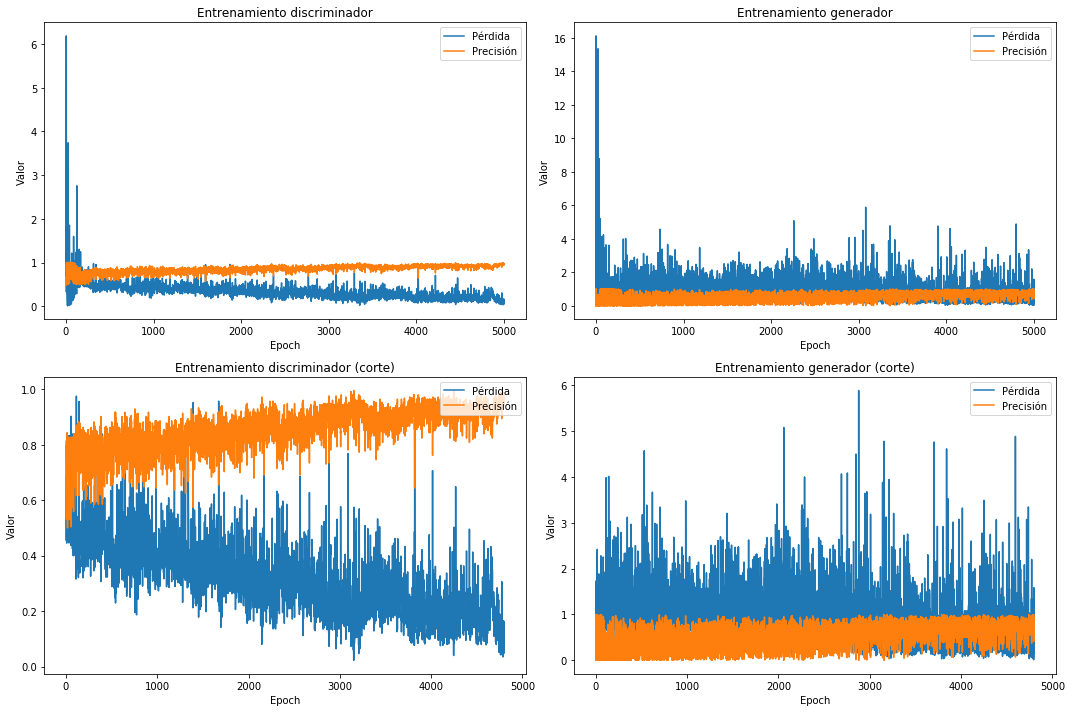

In [82]:
leg=("Pérdida","Precisión")
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
ax = axes.flatten()
ax[0].set_title("Entrenamiento discriminador")
ax[1].set_title("Entrenamiento generador")
ax[2].set_title("Entrenamiento discriminador (corte)")
ax[3].set_title("Entrenamiento generador (corte)")
ax[0].plot(hist["d"])
ax[1].plot(hist["g"])
ax[2].plot(hist["d"][200:])
ax[3].plot(hist["g"][200:])
for i in range(4):
    ax[i].set_ylabel('Valor')
    ax[i].set_xlabel('Epoch')
    ax[i].legend(leg, loc='upper right')
plt.tight_layout()
plt.show()

Se puede observar que el modelo que más cambios presenta es el discriminador, el cuál mejora de manera constante su precisión y disminuye lentamente su pérdida. El modelo adversario muestra un comportamiento similar en cuanto a su precisión, lentamente mejorando su precisión, sin embargo la pérdida de este es más difícil de apreciar debido a su alta variabilidad.

La mejora marginal de los modelos a lo largo de 5000 epochs puede deberse a lo anteriormente indicado, como ninguno de los dos componentes está debidamente entrenado, se realentiza el aprendizaje de ambos.

Además se hace un gráfico para comparar las precisiones y pérdidas de ambos modelos.

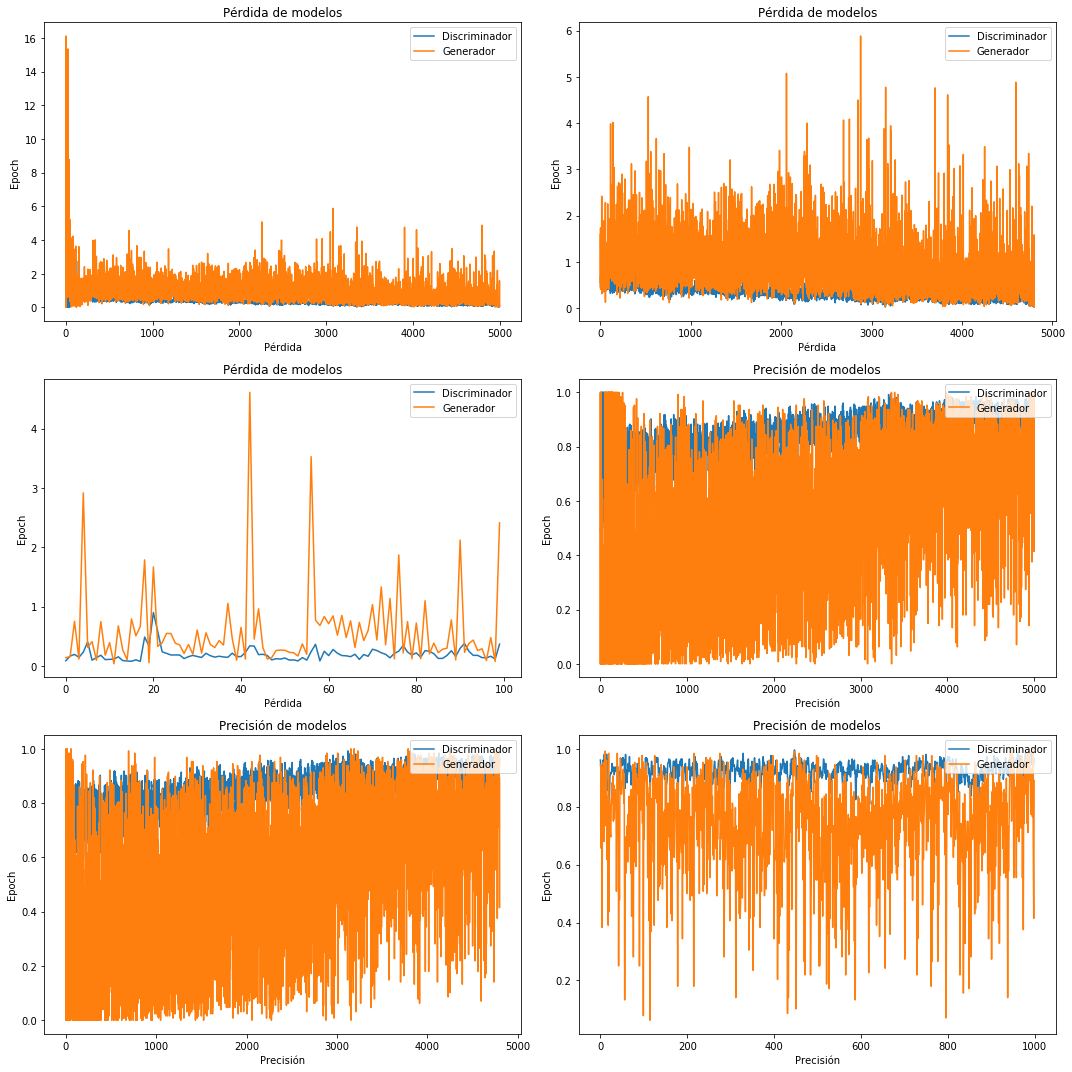

In [83]:
isThis=[]
acc=[]
for i in range(len(hist["d"])):
    isThis.append((hist["d"][i][0],hist["g"][i][0]))
    acc.append((hist["d"][i][1],hist["g"][i][1]))
leg=["Discriminador","Generador"]
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15))
ax = axes.flatten()
ax[0].plot(isThis)
ax[1].plot(isThis[200:])
ax[2].plot(isThis[4000:4100])
ax[3].plot(acc)
ax[4].plot(acc[200:])
ax[5].plot(acc[4000:5000])
for i in range(6):
    if(i<3):
        ax[i].set_title('Pérdida de modelos')
        ax[i].set_ylabel('Epoch')
        ax[i].set_xlabel('Pérdida')
        ax[i].legend(leg, loc='upper right')
    else:
        ax[i].set_title('Precisión de modelos')
        ax[i].set_ylabel('Epoch')
        ax[i].set_xlabel('Precisión')
        ax[i].legend(leg, loc='upper right')

plt.tight_layout()
plt.show()

Del gráfico se puede apreciar que los valores de pérdida del generador siempre van por sobre el del discriminador, y los valores de precisión del discriminador siempre son mejores y estables respecto al del generador. De esto se puede intuir que el desempeño del modelo generativo adversarial va a estar acotado por el desempeño del discriminador que utilice.

Parte e)

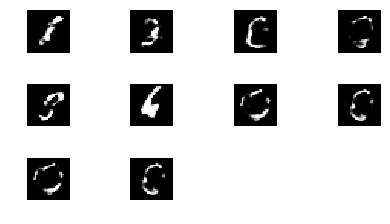

In [86]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Parte f)